## Description

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
pd.set_option('display.max_columns',None)
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from pprint import pprint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Download necessary libraries

In [2]:
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('vader_lexicon')

## Read Data

In [3]:
train_df = pd.read_csv("../data/Twitter/twitter_training.csv",header=None)
test_df = pd.read_csv("../data/Twitter/twitter_validation.csv",header=None)
train_df.columns = ['number','topic','sentiment','tweet']
test_df.columns = ['number','topic','sentiment','tweet']

In [4]:
train_df.head()

,number,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
test_df.head()

,number,topic,sentiment,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## Short Data Summary

In [6]:
train_df.shape, test_df.shape

((74682, 4), (1000, 4))

In [7]:
train_df.sentiment.unique(), test_df.sentiment.unique()

(array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object),
 array(['Irrelevant', 'Neutral', 'Negative', 'Positive'], dtype=object))

In [8]:
train_df.groupby("sentiment").count()

,number,topic,tweet
sentiment,,,
Irrelevant,12990,12990,12875
Negative,22542,22542,22358
Neutral,18318,18318,18108
Positive,20832,20832,20655


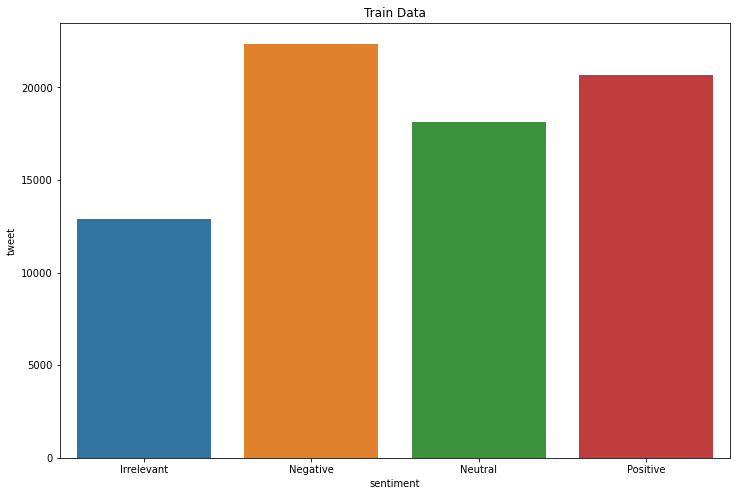

In [9]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(data=train_df.groupby('sentiment').count().reset_index(), x='sentiment', y='tweet',ax = ax)
plt.title("Train Data")
plt.show()
plt.close()

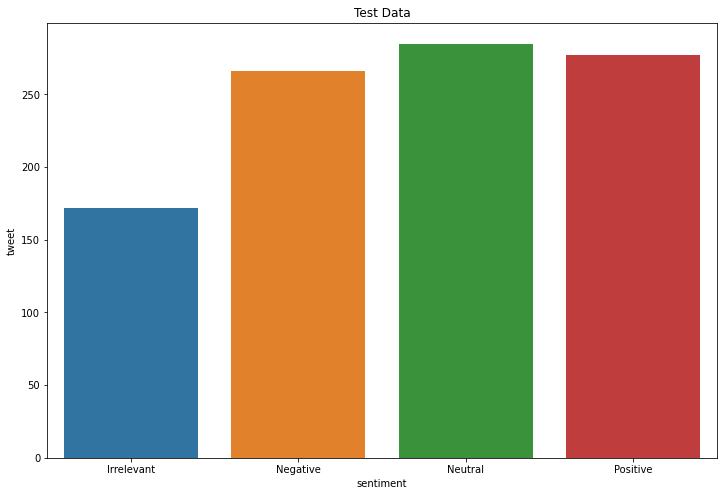

In [10]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(data=test_df.groupby('sentiment').count().reset_index(), x='sentiment', y='tweet',ax = ax)
plt.title("Test Data")
plt.show()
plt.close()

### Data Preprocessing - encode sentiment // keep only sentiment &tweet

In [11]:
train_df.head()

,number,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [12]:
test_df.head()

,number,topic,sentiment,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [13]:
train_df.groupby('sentiment').count()

,number,topic,tweet
sentiment,,,
Irrelevant,12990,12990,12875
Negative,22542,22542,22358
Neutral,18318,18318,18108
Positive,20832,20832,20655


In [14]:
test_df.groupby('sentiment').count()

,number,topic,tweet
sentiment,,,
Irrelevant,172,172,172
Negative,266,266,266
Neutral,285,285,285
Positive,277,277,277


In [15]:
train_df.head()

,number,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [16]:
train_df.sentiment.unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [17]:
test_df.sentiment.unique()

array(['Irrelevant', 'Neutral', 'Negative', 'Positive'], dtype=object)

In [18]:
def process_sentiment(df):
    df = df[df['sentiment'].isin(['Positive','Negative'])]
    df.loc[df.sentiment=='Positive', 'sentiment'] = 1
    df.loc[df.sentiment=='Negative', 'sentiment'] = 0
    df['sentiment'] = df['sentiment'].astype(int)
    #df.drop(['number','topic'],axis=1,inplace=True)
    return df[['tweet','sentiment']]

In [19]:
train_df = process_sentiment(train_df)
test_df = process_sentiment(test_df)

/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/f7/frkz7fzd1hd5r3hc24670dnm0000gn/T/ipykernel_19381/1113983635.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].astype(int)


In [20]:
train_df['sentiment'].unique(), test_df['sentiment'].unique()

(array([2, 1, 0]), array([1, 0, 2]))

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61692 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      61121 non-null  object
 1   sentiment  61692 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 1 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      828 non-null    object
 1   sentiment  828 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 19.4+ KB


# Tweet Processing

In [23]:
# use pipeline

In [24]:
# define stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [25]:
def text_process(text):
    text = re.sub("[^a-zA-Z]"," ",str(text))
    # convert to lower case
    text = text.lower().split()
    text = set([lemmatizer.lemmatize(str(x)) for x in text]) #lemmatizing
    text = [w for w in text if not w in stop_words]
    text = " ".join(text)
    return text

In [26]:
train_df.head()

,tweet,sentiment
0,im getting on borderlands and i will murder yo...,2
1,I am coming to the borders and I will kill you...,2
2,im getting on borderlands and i will kill you ...,2
3,im coming on borderlands and i will murder you...,2
4,im getting on borderlands 2 and i will murder ...,2


In [27]:
train_df['tweet'] = [text_process(text) for text in train_df['tweet']]

In [28]:
test_df['tweet'] = [text_process(text) for text in test_df['tweet']]

In [29]:
train_df.head()

,tweet,sentiment
0,borderland im getting murder,2
1,border coming kill,2
2,borderland im getting kill,2
3,borderland im murder coming,2
4,borderland im getting murder,2


In [30]:
test_df.head()

,tweet,sentiment
1,drug bezos news claim acted like jeff amazon r...,1
2,poorly microsoft samsungus function pay chrome...,0
3,truly hacking awful full matchmaking closet cs...,0
4,president discover commit acquittal slapping g...,1
5,fifa whilst working please help past hi card a...,0


# Train Test Split

In [31]:
X = train_df["tweet"]
Y = train_df["sentiment"]

In [32]:
train_X,valid_X, train_Y,valid_Y = train_test_split(X,
    Y, test_size=0.33,random_state=100)

In [33]:
test_X,test_Y = test_df['tweet'], test_df['sentiment']

In [34]:
train_X

29752                         give crumb u lobalore please
55455                       call spire slay decision honor
70262                      loot ghostrecon sometimes worth
43453                                                  wow
7687     streaming overwatch hanging care arse console ...
                               ...                        
14933                           playing damn blackout dota
70067                                                     
17345       someone like stuck look p microwave around far
68652    cdprojektred need love always supporting cant ...
47324                     depot beating go home flamboyant
Name: tweet, Length: 41333, dtype: object

In [35]:
tfidf = TfidfVectorizer()
train_X = tfidf.fit_transform(train_X).toarray()
valid_X = tfidf.transform(valid_X).toarray()
test_X = tfidf.transform(test_X).toarray()

In [36]:
train_X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Train  Models

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans

In [38]:
## Dummy Classification
dummy_model = DummyClassifier().fit(train_X, train_Y)
lr = LogisticRegression().fit(train_X, train_Y)
dt = DecisionTreeClassifier().fit(train_X,train_Y)
knn = KNeighborsClassifier().fit(train_X,train_Y)
nb = GaussianNB().fit(train_X, train_Y)
km = KMeans(n_clusters=2).fit(train_X,train_Y)

/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
dum_pred = dummy_model.predict(valid_X)
lr_pred = lr.predict(valid_X)
dt_pred = dt.predict(valid_X)
knn_pred = knn.predict(valid_X)
nb_pred = nb.predict(valid_X)

In [37]:
dum_val_prob = dummy_model.predict_proba(valid_X)
lr__val_prob = lr.predict_proba(valid_X)
dt__val_prob = dt.predict_proba(valid_X)
knn__val_prob = knn.predict_proba(valid_X)
nb__val_prob = nb.predict_proba(valid_X)


# Evaluate

In [38]:
y_val = valid_Y.values
print("================DUMMY MODEL================")
print("Accuracy Score: {}".format(accuracy_score(y_val, dum_pred)))
print("================LR MODEL================")
print("Accuracy Score: {}".format(accuracy_score(y_val, lr_pred)))
print("================DT MODEL================")
print("Accuracy Score: {}".format(accuracy_score(y_val, dt_pred)))

print("================KNN MODEL================")
print("Accuracy Score: {}".format(accuracy_score(y_val, knn_pred)))

print("================NB MODEL================")
print("Accuracy Score: {}".format(accuracy_score(y_val, nb_pred)))

================DUMMY MODEL================
Accuracy Score: 0.5167668017325695
================LR MODEL================
Accuracy Score: 0.8745982953751572
================DT MODEL================
Accuracy Score: 0.8893391085650412
================KNN MODEL================
Accuracy Score: 0.9006566997345257
================NB MODEL================
Accuracy Score: 0.8091379069442504


# Test Results

In [39]:
test_dum = dummy_model.predict(test_X)
test_lr = lr.predict(test_X)
test_dt = dt.predict(test_X)
test_knn = knn.predict(test_X)
test_nb = nb.predict(test_X)

In [40]:
y_test = test_Y.values
print("================DUMMY MODEL================")
print("Accuracy Score: {}".format(accuracy_score(y_test, test_dum)))
print("================LR MODEL================")
print("Accuracy Score: {}".format(accuracy_score(y_test, test_lr)))
print("================DT MODEL================")
print("Accuracy Score: {}".format(accuracy_score(y_test, test_dt)))

print("================KNN MODEL================")
print("Accuracy Score: {}".format(accuracy_score(y_test, test_knn)))
print("================NB MODEL================")
print("Accuracy Score: {}".format(accuracy_score(y_test, test_nb)))

================DUMMY MODEL================
Accuracy Score: 0.48987108655616945
================LR MODEL================
Accuracy Score: 0.9484346224677717
================DT MODEL================
Accuracy Score: 0.9668508287292817
================KNN MODEL================
Accuracy Score: 0.9484346224677717
================NB MODEL================
Accuracy Score: 0.860036832412523


### Confusion Matrix

In [41]:
print("Dummy Model")
print(pd.crosstab(y_test, test_dum, rownames=['Actual'], colnames=['Predicted'],margins=True,normalize='index'))
print("LogisticRegression")
print(pd.crosstab(y_test, test_lr, rownames=['Actual'], colnames=['Predicted'],margins=True,normalize='index'))
print("Decision Tree")
print(pd.crosstab(y_test, test_dt, rownames=['Actual'], colnames=['Predicted'],margins=True,normalize='index'))
print("KNN")
print(pd.crosstab(y_test, test_knn, rownames=['Actual'], colnames=['Predicted'],margins=True,normalize='index'))
print("Gaussian NB Regression")
print(pd.crosstab(y_test, test_nb, rownames=['Actual'], colnames=['Predicted'],margins=True,normalize='index'))

Dummy Model
Predicted    0
Actual        
0          1.0
1          1.0
All        1.0
LogisticRegression
Predicted         0         1
Actual                       
0          0.954887  0.045113
1          0.057762  0.942238
All        0.497238  0.502762
Decision Tree
Predicted         0         1
Actual                       
0          0.969925  0.030075
1          0.036101  0.963899
All        0.493554  0.506446
KNN
Predicted         0         1
Actual                       
0          0.958647  0.041353
1          0.061372  0.938628
All        0.500921  0.499079
Gaussian NB Regression
Predicted         0         1
Actual                       
0          0.751880  0.248120
1          0.036101  0.963899
All        0.386740  0.613260


# PR Curve Optimization

In [42]:
lr_val_prob = lr.predict_proba(valid_X)
dt_val_prob = dt.predict_proba(valid_X)
knn_val_prob = knn.predict_proba(valid_X)
nb_val_prob = nb.predict_proba(valid_X)

In [43]:
prec_lr, rec_lr, proba_lr = precision_recall_curve(valid_Y, lr_val_prob[:,-1])
prec_dt, rec_dt, proba_dt = precision_recall_curve(valid_Y, dt_val_prob[:,-1])
prec_knn, rec_knn, proba_knn = precision_recall_curve(valid_Y, knn_val_prob[:,-1])
prec_nb, rec_nb, proba_nb = precision_recall_curve(valid_Y, nb_val_prob[:,-1])

/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


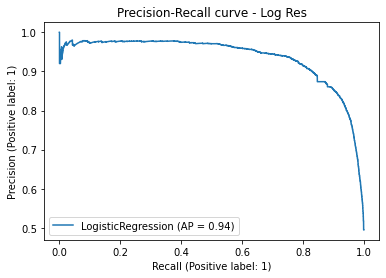

/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


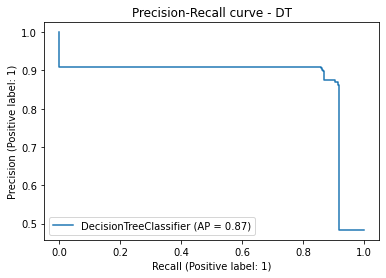

/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


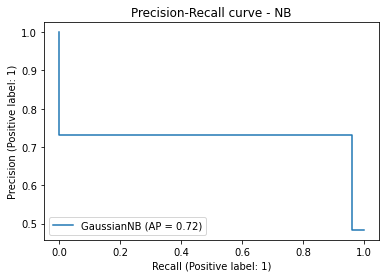

/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


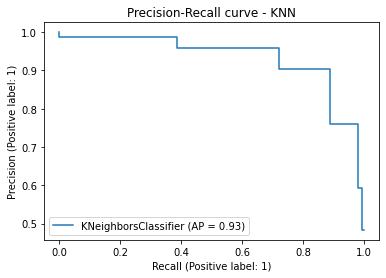

In [44]:
disp = plot_precision_recall_curve(lr, valid_X, valid_Y)
disp.ax_.set_title('Precision-Recall curve - Log Res')
plt.show()
plt.close()
disp = plot_precision_recall_curve(dt, valid_X, valid_Y)
disp.ax_.set_title('Precision-Recall curve - DT')
plt.show()
plt.close()
disp = plot_precision_recall_curve(nb, valid_X, valid_Y)
disp.ax_.set_title('Precision-Recall curve - NB')
plt.show()
plt.close()

disp = plot_precision_recall_curve(knn, valid_X, valid_Y)
disp.ax_.set_title('Precision-Recall curve - KNN')
plt.show()
plt.close()

### Optimal Cutoff

In [48]:
optimal_cutoff_lr = sorted(list(zip(np.abs(prec_lr - rec_lr), proba_lr)), key=lambda i: i[0], reverse=False)[0][1]
roc_pred_lr = [1 if i >= optimal_cutoff_lr else 0 for i in lr_val_prob[:, -1]]
optimal_cutoff_lr = sorted(list(zip(np.abs(prec_lr - rec_lr), proba_lr)), key=lambda i: i[0], reverse=False)[0][1]
roc_pred_lr = [1 if i >= optimal_cutoff_lr else 0 for i in lr_val_prob[:, -1]]
optimal_cutoff_dt = sorted(list(zip(np.abs(prec_dt - rec_dt), proba_dt)), key=lambda i: i[0], reverse=False)[0][1]
roc_pred_dt = [1 if i >= optimal_cutoff_dt else 0 for i in dt_val_prob[:, -1]]
optimal_cutoff_nb = sorted(list(zip(np.abs(prec_nb - rec_nb), proba_nb)), key=lambda i: i[0], reverse=False)[0][1]
roc_pred_nb = [1 if i >= optimal_cutoff_nb else 0 for i in nb_val_prob[:, -1]]
optimal_cutoff_knn = sorted(list(zip(np.abs(prec_knn - rec_knn), proba_knn)), key=lambda i: i[0], reverse=False)[0][1]
roc_pred_knn = [1 if i >= optimal_cutoff_knn else 0 for i in knn_val_prob[:, -1]]

# Evaluation after thresholding

In [49]:
print("Logistic Regression")
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(valid_Y, lr_pred), accuracy_score(valid_Y, roc_pred_lr)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(valid_Y, lr_pred), precision_score(valid_Y, roc_pred_lr)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(valid_Y, lr_pred), recall_score(valid_Y, roc_pred_lr)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(valid_Y, lr_pred), f1_score(valid_Y, roc_pred_lr)))

Logistic Regression
Accuracy Score Before and After Thresholding: 0.8745982953751572, 0.8774626240044712
Precision Score Before and After Thresholding: 0.8903963414634146, 0.8732109295937546
Recall Score Before and After Thresholding: 0.8444412317478676, 0.8732109295937546
F1 Score Before and After Thresholding: 0.8668101209467982, 0.8732109295937546


In [50]:
print("Decision Tree Regression")
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(valid_Y, dt_pred), accuracy_score(valid_Y, roc_pred_dt)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(valid_Y, dt_pred), precision_score(valid_Y, roc_pred_dt)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(valid_Y, dt_pred), recall_score(valid_Y, roc_pred_dt)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(valid_Y, dt_pred), f1_score(valid_Y, roc_pred_dt)))

Decision Tree Regression
Accuracy Score Before and After Thresholding: 0.8893391085650412, 0.8922034371943551
Precision Score Before and After Thresholding: 0.9006761833208115, 0.8763305322128851
Recall Score Before and After Thresholding: 0.8665606476796299, 0.9045829116669076
F1 Score Before and After Thresholding: 0.883289124668435, 0.8902326243152877


In [51]:
print("NB")
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(valid_Y, nb_pred), accuracy_score(valid_Y, roc_pred_nb)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(valid_Y, nb_pred), precision_score(valid_Y, roc_pred_nb)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(valid_Y, nb_pred), recall_score(valid_Y, roc_pred_nb)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(valid_Y, nb_pred), f1_score(valid_Y, roc_pred_nb)))

NB
Accuracy Score Before and After Thresholding: 0.8091379069442504, 0.8094173536397932
Precision Score Before and After Thresholding: 0.7301220719234576, 0.7304433931125537
Recall Score Before and After Thresholding: 0.9598091658233339, 0.9598091658233339
F1 Score Before and After Thresholding: 0.8293566520924421, 0.8295639135324254


In [52]:
print("KNN")
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(valid_Y, knn_pred), accuracy_score(valid_Y, roc_pred_knn)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(valid_Y, knn_pred), precision_score(valid_Y, roc_pred_knn)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(valid_Y, knn_pred), recall_score(valid_Y, roc_pred_knn)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(valid_Y, knn_pred), f1_score(valid_Y, roc_pred_knn)))

KNN
Accuracy Score Before and After Thresholding: 0.9006566997345257, 0.9006566997345257
Precision Score Before and After Thresholding: 0.9029183164686905, 0.9029183164686905
Recall Score Before and After Thresholding: 0.8901257770709845, 0.8901257770709845
F1 Score Before and After Thresholding: 0.8964764123471172, 0.8964764123471172
